In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
import matplotlib.pyplot as plt
import time
def elapsed(sec):
    if sec < 60:
        return "{:.2f}".format(sec) + " sec"
    elif sec < (60 * 60):
        return "{:.2f}".format(sec / 60) + " min"
    else:
        return "{:.2f}".format(sec / (60 * 60)) + " hr"
def showimg(img):
    plt.figure("Image")
    plt.imshow(img,cmap='gray')
    plt.axis('on')
    plt.title('image')
    plt.show()

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
HIDDEN_SIZE=512
INPUT_SIZE=31
OUTPUT_SIZE=28
BATCH_SIZE=128
NUM_LAYERS=2
TIMESTEPS_IN=28
TIMESTEPS_OUT=28
INDEX_WEIGHT=1
is_training = tf.placeholder(tf.bool)

In [4]:
encoder_inputs = tf.placeholder(shape=(None, TIMESTEPS_IN, INPUT_SIZE), dtype=tf.float32, name='encoder_inputs')

encoder_cell = tf.contrib.rnn.LSTMCell(HIDDEN_SIZE)
encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(encoder_cell, encoder_inputs,dtype=tf.float32)
del encoder_outputs

#start_tokens = np.array([0]).repeat(BATCH_SIZE*3)
start_tokens=tf.placeholder(shape=[None],dtype=tf.int32,  name='start_tokens')
end_token = -1

decoder_embedding = tf.Variable(tf.truncated_normal(shape=[OUTPUT_SIZE,OUTPUT_SIZE], stddev=0.1),name='decoder_embedding')
from tensorflow.python.layers import core
import tensorflow.contrib.layers as layers

output_layer = core.Dense(OUTPUT_SIZE, activation=tf.nn.relu, use_bias=True, name="output_projection",
    kernel_initializer=layers.variance_scaling_initializer(factor=1.0,uniform=True))


decoder_cell = tf.contrib.rnn.LSTMCell(HIDDEN_SIZE)
helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
    decoder_embedding, start_tokens, end_token)

decoder = tf.contrib.seq2seq.BasicDecoder(
    decoder_cell, helper, encoder_final_state, output_layer=output_layer)

outputs, final_context_state,_ = tf.contrib.seq2seq.dynamic_decode(
    decoder=decoder, maximum_iterations=TIMESTEPS_OUT, swap_memory=True)

y=outputs.rnn_output

In [5]:
def prepbatch(BATCH_SIZE,INDEX_WEIGHT):
    batch_xs, batch_ys = mnist.train.next_batch(BATCH_SIZE)
    inp=[]
    tran=[]
    ind=np.zeros(3)
    for i in range(len(batch_xs)):
        t_=batch_xs[i].reshape(28,28)
        t_=t_.reshape(-1)
        tran.append(t_)
        z=ind
        z[0]=INDEX_WEIGHT
        z=np.tile(z,28).reshape(28,-1)
        inp_=np.append(batch_xs[i].reshape(28,28),z,axis=1)
        inp.append(inp_)
    for i in range(len(batch_xs)):
        t_=batch_xs[i][::-1].reshape(28,28)
        t_=t_.reshape(-1)
        tran.append(t_)
        z=ind
        z[1]=INDEX_WEIGHT
        z=np.tile(z,28).reshape(28,-1)
        inp_=np.append(batch_xs[i].reshape(28,28),z,axis=1)
        inp.append(inp_)
    for i in range(len(batch_xs)):
        im=batch_xs[i].reshape(28,28)
        im_=np.zeros((im.shape[1],im.shape[0]))
        for j in range(im.shape[0]):
            im_[:,-j]=im[j]
        t_=im_
        t_=t_.reshape(-1)
        tran.append(t_)
        z=ind
        z[2]=INDEX_WEIGHT
        z=np.tile(z,28).reshape(28,-1)
        inp_=np.append(batch_xs[i].reshape(28,28),z,axis=1)
        inp.append(inp_)
    inp=np.array(inp).reshape(-1,28,31)
    tran=np.array(tran).reshape(-1,28,28)
    s_token=np.zeros((BATCH_SIZE*3))
    return inp,tran,s_token

In [6]:
global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(0.001,global_step,2000, 0.98, staircase=True) 

In [7]:
x = tf.placeholder("float", [None, TIMESTEPS_IN, INPUT_SIZE])
labels=tf.placeholder(tf.float32, [None, TIMESTEPS_OUT,OUTPUT_SIZE])


sess = tf.InteractiveSession()
loss=tf.losses.mean_squared_error(labels,y)
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss,global_step=global_step)
init = tf.global_variables_initializer()
sess.run(init)

In [11]:
def showtrain(num,INDEX_WEIGHT):
    for j in range(num):
        print('TRAIN SET:')
        batch_xs,unuse=mnist.train.next_batch(1)
        newimg=batch_xs.reshape(-1)
        ind=np.zeros(3)
        plt.subplot(231)
        plt.imshow(newimg.reshape(28,28),cmap='gray')
        z=ind
        z[0]=INDEX_WEIGHT
        z=np.tile(z,28).reshape(28,-1)
        inpt=np.append(newimg.reshape(28,28),z,axis=1)
        inpt=inpt.reshape(1,28,-1)
        oupt=sess.run(y,feed_dict={encoder_inputs:inpt,is_training:False,start_tokens:np.zeros(1)})
        plt.subplot(234)
        plt.imshow(oupt.reshape(28,28),cmap='gray')
        newimg1=newimg[::-1].reshape(28,28)
        newimg1=newimg1.reshape(-1)
        plt.subplot(232)
        plt.imshow(newimg1.reshape(28,28),cmap='gray')
        z=ind
        z[1]=INDEX_WEIGHT
        z=np.tile(z,28).reshape(28,-1)
        inpt=np.append(newimg.reshape(28,28),z,axis=1)
        inpt=inpt.reshape(1,28,-1)
        oupt=sess.run(y,feed_dict={encoder_inputs:inpt,is_training:False,start_tokens:np.zeros(1)})
        plt.subplot(235)
        plt.imshow(oupt.reshape(28,28),cmap='gray')
        im=newimg.reshape(28,28)
        im_=np.zeros((im.shape[1],im.shape[0]))
        for i in range(im.shape[0]):
            im_[:,-i]=im[i]
        plt.subplot(233)
        plt.imshow(im_.reshape(28,28),cmap='gray')
        z=ind
        z[2]=INDEX_WEIGHT
        z=np.tile(z,28).reshape(28,-1)
        inpt=np.append(newimg.reshape(28,28),z,axis=1)
        inpt=inpt.reshape(1,28,-1)
        oupt=sess.run(y,feed_dict={encoder_inputs:inpt,is_training:False,start_tokens:np.zeros(1)})
        plt.subplot(236)
        plt.imshow(oupt.reshape(28,28),cmap='gray')
        plt.show()
def showtest(num,INDEX_WEIGHT):
    print('TEST SET:')
    for j in range(num):
        newimg,lb=mnist.test.next_batch(1)
        newimg=newimg.reshape(-1)
        ind=np.zeros(3)
        #print('GROUND TRUTH1:')
        #showimg(newimg.reshape(28,28))
        plt.subplot(231)
        plt.imshow(newimg.reshape(28,28),cmap='gray')
        #print('TRANS1:')
        z=ind
        z[0]=INDEX_WEIGHT
        z=np.tile(z,28).reshape(28,-1)
        inpt=np.append(newimg.reshape(28,28),z,axis=1)
        inpt=inpt.reshape(1,28,-1)
        oupt=sess.run(y,feed_dict={encoder_inputs:inpt,is_training:False,start_tokens:np.zeros(1)})
        plt.subplot(234)
        plt.imshow(oupt.reshape(28,28),cmap='gray')
        #showimg(oupt.reshape(28,28))
        #print('GROUND TRUTH2:')
        newimg1=newimg[::-1].reshape(28,28)
        newimg1=newimg1.reshape(-1)
        #showimg(newimg1.reshape(28,28))
        plt.subplot(232)
        plt.imshow(newimg1.reshape(28,28),cmap='gray')
        #print('TRANS2:')
        z=ind
        z[1]=INDEX_WEIGHT
        z=np.tile(z,28).reshape(28,-1)
        inpt=np.append(newimg.reshape(28,28),z,axis=1)
        inpt=inpt.reshape(1,28,-1)
        oupt=sess.run(y,feed_dict={encoder_inputs:inpt,is_training:False,start_tokens:np.zeros(1)})
        #showimg(oupt.reshape(28,28))
        plt.subplot(235)
        plt.imshow(oupt.reshape(28,28),cmap='gray')
        #print('GROUND TRUTH3:')
        im=newimg.reshape(28,28)
        im_=np.zeros((im.shape[1],im.shape[0]))
        for i in range(im.shape[0]):
            im_[:,-i]=im[i]
        #showimg(im_)
        plt.subplot(233)
        plt.imshow(im_.reshape(28,28),cmap='gray')
        #print('TRANS3:')
        z=ind
        z[2]=INDEX_WEIGHT
        z=np.tile(z,28).reshape(28,-1)
        inpt=np.append(newimg.reshape(28,28),z,axis=1)
        inpt=inpt.reshape(1,28,-1)
        oupt=sess.run(y,feed_dict={encoder_inputs:inpt,is_training:False,start_tokens:np.zeros(1)})
        #showimg(oupt.reshape(28,28))
        plt.subplot(236)
        plt.imshow(oupt.reshape(28,28),cmap='gray')
        plt.show()

0.0072263745
TRAIN SET:


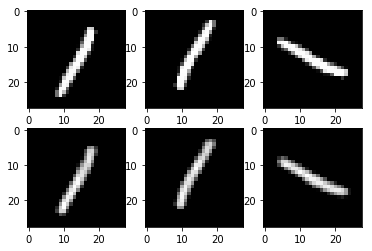

TRAIN SET:


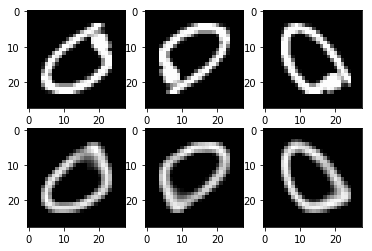

TEST SET:


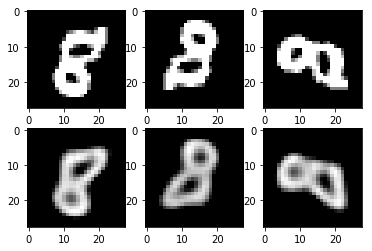

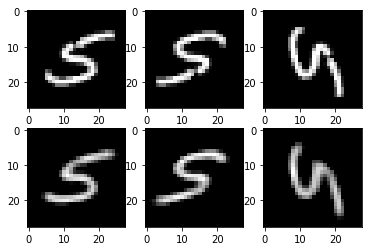

TPI:0.19715094423294066sec
0.006403372
0.005356219
0.0042775148
0.0035921591
0.0034901812
TRAIN SET:


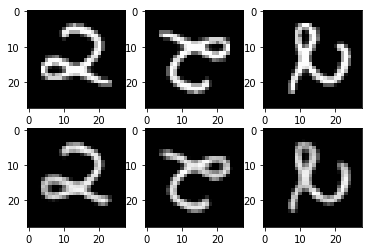

TRAIN SET:


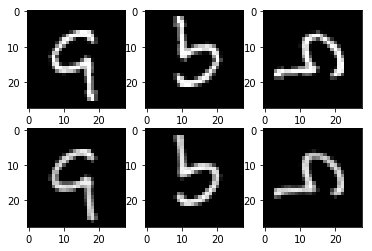

TEST SET:


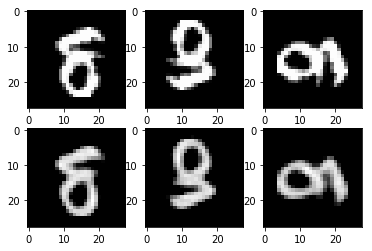

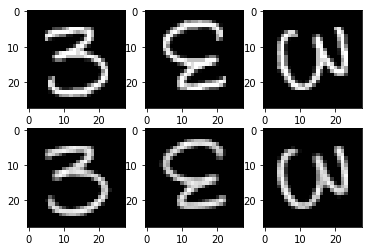

0.0032898525
0.002890438
0.0026274219
0.002654105
0.0022985707
TRAIN SET:


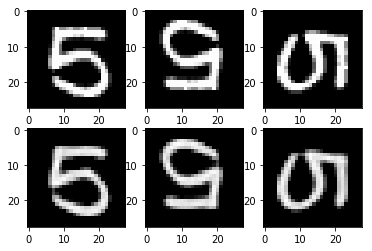

TRAIN SET:


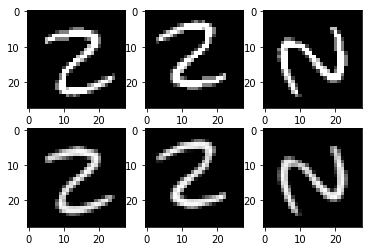

TEST SET:


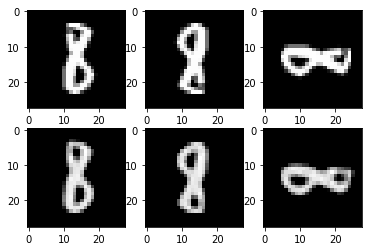

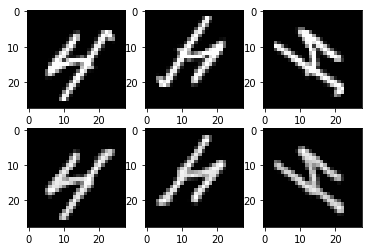

0.002384705


KeyboardInterrupt: 

In [12]:
cost=1
i=0
start_time=time.time()
while cost>0.000001:
    inp,tran,s_token=prepbatch(BATCH_SIZE,INDEX_WEIGHT)
    unuse,cost=sess.run([optimizer,loss],feed_dict={encoder_inputs:inp,labels:tran,is_training:True,start_tokens:s_token})
    if i % 1000==0:
        print(cost)
    if i==500:
        tpi=(time.time() - start_time)/500
        print('TPI:'+str(tpi)+'sec')
    if i%5000==0:
        showtrain(2,INDEX_WEIGHT)
        showtest(2,INDEX_WEIGHT)

    i+=1
print('ITERATION:'+str(i))
print("Elapsed time: ", elapsed(time.time() - start_time))